# Kmeans

Kmeans is an algorithm unsupervised clustering, that aims to partition n obser-vations into k clusters in which each observation belongs to the cluster with thenearest mean (cluster centers or cluster centroid),  serving as a prototype of the cluster.

## 1. serial implementation

Here is a simple serial implementation of the algorithm 

In [2]:
import numpy as np


def computeDistanceToCentroid( points , centroid ):
	""" computes the squared euclidian distance between a set of <points> and a <centroid>.
		<points> is a 'number of dimensions'*n array
		<centroid> is a 1*'number of dimensions' array

		the distances are returned as a 1*n array

	doctest strings :

	>>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
	>>> c = np.array([ 0.5, 0.5])
	>>> computeDistanceToCentroid(p,c)
	array([[0.5, 0.5, 0.5, 0.5]])

	""" 
	distances = np.zeros([1,points.shape[1]])
	for i in range( points.shape[0] ):
		distances += np.power( points[i,] - centroid[i] , 2 )
	return distances

def computeNearestCentroid( points , centroids ):
	""" computes the closest <centroid> for each point in <points>
		<points> is a 'number of dimensions'*n array
		<centroids> is a list of 1*'number of dimensions' array

		The closest are returned as a 1*n array
		that contains the index of the closest centroid


	doctest strings :

	>>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
	>>> c = [ np.array([ -0.5, 0.5]) , np.array([ 1.5, 0.5]) ]
	>>> computeNearestCentroid(p,c)
	array([0, 0, 1, 1])

	""" 

	nbPoints = points.shape[1]
	nbCentroids = len(centroids)

	#1. computing distances 
	distances = np.empty([ nbCentroids , nbPoints ])
	for i in range( nbCentroids ):
		distances[i,] = computeDistanceToCentroid( points , centroids[i] )

	#2. finding the closest centroid for each point
	closestCentroid = np.apply_along_axis(np.argmin , 0 , distances )
	
	return closestCentroid

def computeCentroids( points , assignments , k ):
	""" computes the centroids for <points> with a given <assignment>
		<points> is a 'number of dimensions'*n array
		<assignements> is a 1*n array containing indexes from 0 to <k>
		

		Centroids are returned as a list of 'number of dimensions'*1 arrays

	doctest strings :

	>>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
	>>> a = np.array([0, 0, 1, 1])
	>>> computeCentroids( p , a , 2 )
	[array([0. , 0.5]), array([1. , 0.5])]
	"""
	nbDim = points.shape[0]
	nbPoint = points.shape[1]

	centroids = [ np.zeros(nbDim) for i in range(k) ]
	clusterSize = [ 0 ] * k

	##summing all values
	for i in range(nbPoint) :
		cluster  = assignments[i]
		centroids[ cluster ] +=  points[:,i]
		clusterSize[ cluster ] += 1
	
	##dividng by cluster size
	for i in range(k):
		centroids[ i ] /= clusterSize[ i ]

	return centroids

def KmeanRound( points , centroids ):
	"""
	For each point, compute the nearest centroid.
	Then computes new centroids based on the assignment.
	

	<points> is a 'number of dimensions'*n array
	<centroids> is a list of 1*'number of dimensions' array

	Returns :
		* the new centroids : list of 'number of dimensions'*1 arrays
		* new assignment : as a 1*n array containing indexes from 0 to k

	"""

	assignment = computeNearestCentroid( points , centroids )
	newCentroids = computeCentroids( points , assignment , len(centroids) )
	return newCentroids,assignment

def Kmeans( points , k , maxNbRounds=1000 , assignment = None ):
	"""
	<points> is a 'number of dimensions'*n array
	<k> : number of clusters
	<maxNbRounds> : maximum number of Kmean round to perform

	Returns a cluster assignment : as a 1*n array containing indexes from 0 to k

	"""
	nbPoints = points.shape[1]

	#1. initialization 
	if assignment is None:
		#I use the random assignment here.
		assignment = np.random.randint(0,k,nbPoints)

	centroids = computeCentroids( points , assignment , k )
	round = 1

	while( round < maxNbRounds ):
		centroids,newAssignment = KmeanRound( points , centroids )

		nbChanged = np.sum( newAssignment != assignment )
		
		assignment = newAssignment
		
		if nbChanged == 0: # nothing has changed -> we have converged !
			break
		elif nbChanged == nbPoints:
			## something fishy occurs -> redraw random points to allow convergence
			assignment = np.random.randint(0,k,nbPoints)
			centroids = computeCentroids( points , assignment , k )

		#print("round {}, {:.2%} points changed assignment".format(round,nbChanged/nbPoints))
		round+=1
		#plotClusters( points , assignment , assignment , dimX=0 , dimY=1 )
		#plt.show()


	return assignment


Let's check that it does what we want :

In [3]:
import matplotlib.pyplot as plt


def generateCluster( n , means , sds ):
	''' 
	draw <n> points 
	from a multidimensional normal distribution 
	of means <means> (list)
	and standard deviation <sds> (list)

	the point are returned as a 'number of dimensions'*<n> array
	'''

	P = np.random.randn( len(means) , n )
	for i in range(len(means)):
		P[i,] = P[i,] * sds[i] + means[i]
	return P


def plotClusters( points , color_assignment , symbol_assignment , dimX=0 , dimY=1 ):
	"""
	plots a scatter plot with the defined color and symbol assignment.
	<points> is a 'number of dimensions'*<n> array
	<dimX> : index of the dimension that will be used as X (default 0)
	<dimY> : index of the dimension that will be used as Y (default 1)

	OK up until 22 symbol assignments
	"""
	symbols = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|",]
	colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
	for i, c in enumerate(np.unique(symbol_assignment)):
		mask = symbol_assignment == c
		plt.scatter(points[dimX,:][mask],
					points[dimY,:][mask],
					c=[ colors[x] for x in color_assignment[mask]], marker=symbols[c])



/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


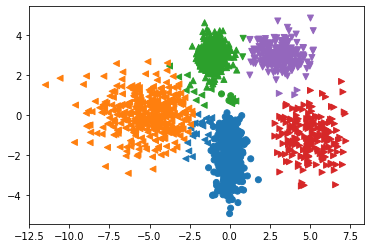

In [10]:

import doctest
test = doctest.testmod() 
if test.failed>0:
	print('doctest failed some tests')
	print(test)
	exit(0)

import time

# generating data

## 5 clusters of points 
clusterSizes = [400,200,400,400,200 ]
clusterMeans = [ [ 0 , -2 ] ,
				 [ 3 , 3 ] ,
				 [ -1 , 3 ], 
				 [-5, 0] , 
				 [5,-1] ]
clusterSDs = [ [0.5,1] ,
			   [1,0.5] ,
			   [0.5,0.5],
			   [2,1] ,
			   [1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]

Points = np.concatenate( C , axis=1)

realAssignment = np.array(A)


# performing Kmean
k=5

kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 )

## plotting : color are the Kmean assignment, symbols are the real assignment
# OK up until 22 real clusters
plotClusters( Points , kmeanAssignment , realAssignment , dimX=0 , dimY=1 )
plt.show()


#	### sk learn version - for culture
#	from sklearn.cluster import KMeans as scKmeans
#	X = Points.T ## scikit learn expects another shpae for the points
#	t0 = time.time()
#	kmeans = scKmeans(n_clusters=k, random_state=0).fit(X)
#	t1 = time.time()
#	print('scikit-learn :',t1-t0,'seconds')



The code seems to do what we want it to. 

Now let's do some profiling :

In [11]:
# generating some random data 
clusterSizes = [4000,2000,4000,4000,2000 ]
clusterMeans = [ [ 0 , -2 ] , [ 3 , 3 ] ,[ -1 , 3 ], [-5, 0] , [5,-1] ]
clusterSDs = [ [0.5,1] ,[1,0.5] ,[0.5,0.5],[2,1] ,[1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]
Points = np.concatenate( C , axis=1)
realAssignment = np.array(A)

# performing Kmean
k=5
%prun kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 ) 
# the %prun magic command activate profiling


/home/wandrille/Installed_software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide


We are mostly interested in the `cumtime` column, which gives the total time spent in the function itself + all functions it calls. 

What I see is that on 2.922 seconds of computations, I spend a total of 2.348 seconds in function `computeNearestCentroid`, and more specifically 2.311 seconds in the `apply_along_axis` line. 

This corresponds to about 80% of execution time spent on that line alone, so I will concentrate my optimization efforts on this line. If I am successful, I could speed up execution time by a factor up to 5.

## 2. Speeding up a single function using numba.cuda 

### problem setup

I reproduce the function that takes up most of the execution time 
(around 80%) in the Kmeans computation.

In itself, the goal of this function is to return the closest centroid for each points, given the set of distances between each point and each centroid.

I propose here a couple of naive implementations to test out :

In [13]:
from numba import cuda
from numba import jit
import numpy as np

def getClosestCentroid( distances ):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    return np.apply_along_axis(np.argmin , 0 , distances )

# here I just want to test if performing the same operation, but along the other axis , would yield better results
def getClosestCentroidTransposed( distances ):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    return np.apply_along_axis(np.argmin , 1 , distances )



@cuda.jit
def getClosestCentroidNaiveCuda( distances , m , closestCentroid):
    '''
        distances : (n,m) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    # here is my naive re-implementation of the function using numba.cuda 
    # here the kernel operates on a single data point
    pos = cuda.grid(1) # getting the point index
    if pos < closestCentroid.size:
        # I go through all distances between that point and the centroids to find the closest one
        # This is purposefully done in the most naive way
        x=1
        minVal=distances[pos,0]
        minInd=0
        while x < m:
            if distances[pos,x]<minVal:
                minVal=distances[pos,x]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    
# here I just want to test if performing the same operation, but along the other axis , would yield better results
@cuda.jit
def getClosestCentroidNaiveCudaColumn( distances , m , closestCentroid):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    pos = cuda.grid(1)
    if pos < closestCentroid.size:
        x=1
        minVal=distances[0,pos]
        minInd=0
        while x < m:
            if distances[x,pos]<minVal:
                minVal=distances[x,pos]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    





Let's test them out on some randomly generated distances :

In [14]:
m=5
n=64000

distances = np.random.random((m,n))
distancesT = distances.T

In [15]:
# similar to my implementation, I keep a fairly naive approach here and use block size of 1 thread.
threadsperblock = 1
blockspergrid = (distancesT.size + (threadsperblock - 1)) // threadsperblock


closestCentroid1 = np.empty((n,))
closestCentroid2 = np.empty((n,))
closestCentroid3 = np.empty((n,))

# the %timeit magic command used here will perform 10 runs of 2 loops each and report execution times.
resCPU = %timeit -n 2 -r 10 -o closestCentroid1 = getClosestCentroidTransposed( distancesT )
resGPU = %timeit -n 2 -r 10 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )
#resGPU2 = %timeit -n 2 -r 10 -o getClosestCentroidNaiveCudaColumn[blockspergrid, threadsperblock]( distances , m , closestCentroid3 )

print("GPU speedup",resCPU.best/resGPU.best)

194 ms ± 2.54 ms per loop (mean ± std. dev. of 10 runs, 2 loops each)


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

Getting a speedup value is nice, but surely this depends heavily on the dimension of the problem, which is basically the number of points (n) and number of clusters (m).

Let's explore the speedup we can achieve for different values :

In [18]:
2**5

32

In [6]:
speedup = np.zeros((11,5))

x = 0
for log2n in np.linspace(10,20,11): # n between 1 024 and 1 048 576
    y=0
    for log2m in np.linspace(1,5,5): # m between 2 and 32
        n = int(2**log2n)
        m = int(2**log2m)
        print(n,m)
        distances = np.random.random((m,n))
        distancesT = distances.T
        closestCentroid1 = np.empty((n,))
        closestCentroid2 = np.empty((n,))

        resCPU = %timeit -n 1 -r 1 -o closestCentroid1 = getClosestCentroidTransposed( distancesT )
        resGPU = %timeit -n 1 -r 1 -o getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distancesT , m , closestCentroid2 )
        speedup[x,y] = resCPU.best/resGPU.best
        y+=1
    x+=1

    

1024 2
9.04 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 4
7.71 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
8.45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 8
6.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
6.83 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 16
6.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4.39 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
1024 32
6.09 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.81 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048 2
10.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.67 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048 4
10.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.15 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2048 8
10.7 ms ± 0 ns per loop (mean ± st

Let's plot the speedups :

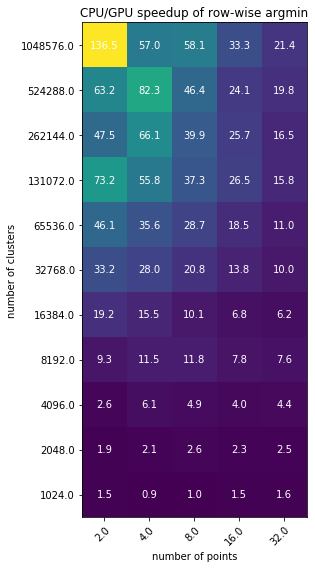

In [15]:
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

N = 2**np.linspace(10,20,11)
M = 2**np.linspace(1,5,5)



fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(speedup)

# We want to show all ticks...
ax.set_xticks(np.arange(len(M)))
ax.set_yticks(np.arange(len(N)))
# ... and label them with the respective list entries
ax.set_xticklabels(M)
ax.set_yticklabels(N)

ax.set_xlabel('number of points')
ax.set_ylabel('number of clusters')

ax.set_xlim(-0.5,len(M)-0.5)
ax.set_ylim(-0.5,len(N)-0.5)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(N)):
    for j in range(len(M)):
        text = ax.text(j, i, '{:.1f}'.format(speedup[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("CPU/GPU speedup of row-wise argmin")
fig.tight_layout()
plt.show()

It would seem our speedup is at its best when the problem is large.


Furthermore, for a constant problem size (ie. along diagonals on the heatmap), the speedup seems generally larger when the number of centroids (m) is the lowest.
This corresponds to the cases where the task of each kernel is low and there can be the most parallel blocks running.


## 3. Testing it in practise

We have seen how to re-implement a single function using numba.cuda.

I will now re-implement the wrapping functions to incorporate my numba.cuda optimized function in the Kmean algorithm.

In [20]:

# this is our numba.cuda function
@cuda.jit
def getClosestCentroidNaiveCuda( distances , m , closestCentroid):
    '''
        distances : (m,n) array where 
            m : number of centroids
            n : number of data points
        closestCentroid : 1,n array
    '''
    pos = cuda.grid(1)
    if pos < closestCentroid.size:
        x=1
        minVal=distances[0,pos]
        minInd=0
        while x < m:
            if distances[x,pos]<minVal:
                minVal=distances[x,pos]
                minInd=x
            x +=1            
        closestCentroid[pos] = minInd
    
#the only changed thing is that it call our cuda function instead of np.apply_along_axis
def computeNearestCentroid_callingCUDA( points , centroids ):
    """ computes the closest <centroid> for each point in <points>
        <points> is a 'number of dimensions'*n array
        <centroids> is a list of 1*'number of dimensions' array

        The closest are returned as a 1*n array
        that contains the index of the closest centroid


    doctest strings :

    >>> p = np.array([[ 0,  0, 1, 1],[ 0,  1, 0, 1]])
    >>> c = [ np.array([ -0.5, 0.5]) , np.array([ 1.5, 0.5]) ]
    >>> computeNearestCentroid(p,c)
    array([0, 0, 1, 1])

    """ 

    nbPoints = points.shape[1]
    nbCentroids = len(centroids)

    #1. computing distances 
    distances = np.empty([ nbCentroids , nbPoints ])
    for i in range( nbCentroids ):
        distances[i,] = computeDistanceToCentroid( points , centroids[i] )

    #2. finding the closest centroid for each point
 
    closestCentroid = np.empty((nbPoints,) , dtype=int)
 

    threadsperblock=1
    blockspergrid = (nbPoints + (threadsperblock - 1)) // threadsperblock

    getClosestCentroidNaiveCuda[blockspergrid, threadsperblock]( distances , nbCentroids , closestCentroid )
 
    #closestCentroid = np.apply_along_axis(np.argmin , 0 , distances )
    
    return closestCentroid

#the only changed thing is that it calls computeNearestCentroid_callingCUDA instead of computeNearestCentroid
def KmeanRound_callingCUDA( points , centroids ):
    """
    For each point, compute the nearest centroid.
    Then computes new centroids based on the assignment.
    

    <points> is a 'number of dimensions'*n array
    <centroids> is a list of 1*'number of dimensions' array

    Returns :
        * the new centroids : list of 'number of dimensions'*1 arrays
        * new assignment : as a 1*n array containing indexes from 0 to k

    """

    assignment = computeNearestCentroid_callingCUDA( points , centroids )
    newCentroids = computeCentroids( points , assignment , len(centroids) )
    return newCentroids,assignment

#the only changed thing is that it calls KmeanRound_callingCUDA instead of KmeanRound
def Kmeans_CUDA( points , k , maxNbRounds=1000 , assignment = None):
    """
    <points> is a 'number of dimensions'*n array
    <k> : number of clusters
    <maxNbRounds> : maximum number of Kmean round to perform

    Returns a cluster assignment : as a 1*n array containing indexes from 0 to k

    """
    nbPoints = points.shape[1]

    #1. initialization 
    if assignment is None:
        #I use the random assignment here.
        assignment = np.random.randint(0,k,nbPoints)

    centroids = computeCentroids( points , assignment , k )
    round = 1

    while( round < maxNbRounds ):
        centroids,newAssignment = KmeanRound_callingCUDA( points , centroids )

        nbChanged = np.sum( newAssignment != assignment )
        
        assignment = newAssignment
        
        if nbChanged == 0: # nothing has changed -> we have converged !
            break
        elif nbChanged == nbPoints:
            ## something fishy occurs -> redraw random points to allow convergence
            assignment = np.random.randint(0,k,nbPoints)
            centroids = computeCentroids( points , assignment , k )

        #print("round {}, {:.2%} points changed assignment".format(round,nbChanged/nbPoints))
        round+=1
        #plotClusters( points , assignment , assignment , dimX=0 , dimY=1 )
        #plt.show()


    return assignment


Now let's two the two version against one another:



In [7]:
from numba import cuda
from numba import jit
import numpy as np
import matplotlib.pyplot as plt

import time

# generating data

## 5 clusters of points 
clusterSizes = [2000,1100,620,400,700 ]
clusterMeans = [ [ 0 , -2 ] ,
				 [ 3 , 3 ] ,
				 [ -1 , 3 ], 
				 [-5, 0] , 
				 [5,-1] ]
clusterSDs = [ [0.5,1] ,
			   [1,0.5] ,
			   [0.5,0.5],
			   [2,1] ,
			   [1,1] ]
C = []
A = []
for i in range( len(clusterSizes) ):
	C.append( Kmeans_serial.generateCluster( clusterSizes[i] , clusterMeans[i] , clusterSDs[i] ) )	
	A += [i]*clusterSizes[i]

Points = np.concatenate( C , axis=1)

realAssignment = np.array(A)


Here there is 5 clusters, and 4820 points. According to our heatmap, the optimized function should have a speedup factor between 5 and 6.
Because this function took about 80% of execution time, that should result in a speedup between ~2.9 and ~2.7 (1/(0.2 + 0.8/speedup))). 

In [8]:

# performing Kmean numba cuda
k=5

InitAssignment = np.random.randint(0,k,sum(clusterSizes))

GPU = %timeit -o kmeanAssignment = Kmeans_CUDA( Points , k , maxNbRounds=1000 , assignment=InitAssignment )
CPU = %timeit -o kmeanAssignment = Kmeans( Points , k , maxNbRounds=1000 , assignment=InitAssignment )

print( "n=",sum(clusterSizes) , '\tk=',k )
print( "numbacuda finished in",GPU.best,'seconds' )
print( "serial finished in",CPU.best,'seconds' )
print('speedup best :',CPU.best/GPU.best)
print('speedup average :',CPU.average/GPU.average)

#Kmeans_serial.plotClusters( Points , kmeanAssignment , realAssignment , dimX=0 , dimY=1 )
#plt.show()



110 ms ± 820 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
253 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
n= 4820 	k= 5
numbacuda finished in 0.10813110768795013 seconds
serial finished in 0.2516786828637123 seconds
speedup best : 2.3275326429654135
speedup average : 2.3034371116814913


These speedup factor are abit less than what we expected.

The next step in the optimization procedure would be to either :
 * continue optimizing `computeNearestCentroid`
 * optimize another function

In our specific case, if your expected problem size is such that you expect`computeNearestCentroid` to be sped up by at least a factor 4, then `computeCentroids` would become the most time consuming function in our code and we could want to spend some time optimizing it.

